# Food Supply Chain Security Using Homomorphic MAC and Merkle Tree

### Install required packages

In [29]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import necessary packages

In [30]:
import hashlib
import json
import random
import time
import json
import sys
import os

### Merkle tree predefined functions

In [31]:
# Hash a single sensor entry into a leaf
def hash_sensor_entry(entry):
    sensor_str = f"{entry['timestamp']}|{entry['temperature']}|{entry['humidity']}|{entry['location']}"
    return hashlib.sha256(sensor_str.encode()).hexdigest()

# Build the full Merkle Tree
def build_merkle_tree(leaves):
    if not leaves:
        return []
    tree = [leaves[:]]  # Copy initial leaves
    while len(tree[-1]) > 1:
        current_level = tree[-1]
        next_level = []
        for i in range(0, len(current_level), 2):
            left = current_level[i]
            right = current_level[i + 1] if i + 1 < len(current_level) else left
            combined = left + right
            parent = hashlib.sha256(combined.encode()).hexdigest()
            next_level.append(parent)
        tree.append(next_level)
    return tree

# Extract Merkle root
def get_merkle_root(tree):
    return tree[-1][0] if tree else None

# Load sensor data and compute leaves
def load_sensor_data(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    sensor_data = data["sensor_data"]
    leaves = [hash_sensor_entry(entry) for entry in sensor_data]
    return sensor_data, leaves

# Merkle proof
def get_merkle_proof(tree, index):
    proof = []
    for level in tree[:-1]:
        sibling_index = index ^ 1
        proof.append(level[sibling_index] if sibling_index < len(level) else level[index])
        index //= 2
    return proof

# Verify proof
def verify_merkle_proof(leaf_hash, proof, root, index):
    computed_hash = leaf_hash
    for sibling_hash in proof:
        if index % 2 == 0:
            combined = computed_hash + sibling_hash  # Left + Right
        else:
            combined = sibling_hash + computed_hash  # Left + Right
        computed_hash = hashlib.sha256(combined.encode()).hexdigest()
        index //= 2
    return computed_hash == root




### Homomorphic Mac predefined functions

In [32]:
from decimal import Decimal, getcontext

# Set decimal precision
getcontext().prec = 12

# Hash input to decimal value
def hash_input(input_str):
    digest = hashlib.sha256(input_str.encode()).hexdigest()
    return Decimal(int(digest, 16) % 10**5)

# Generate homomorphic MAC
def generate_mac_for_value(label: str, value: float, key: Decimal) -> Decimal:
    composite = f"{label}-{value}"
    return hash_input(composite) * key

# Verify aggregate MAC
def verify_mac_for_value(label: str, value: float, provided_mac: Decimal, key: Decimal) -> bool:
    expected_mac = generate_mac_for_value(label, value, key)
    print(f"[DEBUG] Expected MAC for {label}: {expected_mac}")
    print(f"[DEBUG] Provided MAC: {provided_mac}")
    return abs(expected_mac - provided_mac) < Decimal("0.000001")

# Node used only for structure (no rebuild needed now)
class HMACTreeNode:
    def __init__(self, timestamp, temperature, key):
        self.timestamp = timestamp
        self.temperature = Decimal(str(temperature))
        self.key = Decimal(str(key))
        self.tag = self.compute_tag()

    def compute_tag(self):
        composite = f"{self.timestamp}-{self.temperature}"
        hashed = hash_input(composite)
        return hashed * self.key

class HMACTree:
    def __init__(self, key):
        self.key = Decimal(str(key))
        self.aggregate_tag = Decimal(0)
        self.nodes = []

    def insert(self, timestamp, temperature):
        temperature_decimal = Decimal(str(temperature))
        node = HMACTreeNode(timestamp, temperature_decimal, self.key)
        self.nodes.append(node)
        self.aggregate_tag += node.tag  # Algebraic update of the tag

    def compute_aggregates_and_macs(self):
        if not self.nodes:
            return None, None, None, None, None, None

        temperatures = [node.temperature for node in self.nodes]

        avg = sum(temperatures) / len(temperatures)
        min_val = min(temperatures)
        max_val = max(temperatures)

        avg_mac = generate_mac_for_value("AVG", avg, self.key)
        min_mac = generate_mac_for_value("MIN", min_val, self.key)
        max_mac = generate_mac_for_value("MAX", max_val, self.key)

        return avg, min_val, max_val, avg_mac, min_mac, max_mac

    def verify_aggregate_mac(self, label, value, provided_mac):
        return verify_mac_for_value(label, value, provided_mac, self.key)


### ZKP predefined functions

In [33]:
import hashlib
import os

def hash_value(val: str) -> str:
    return hashlib.sha256(val.encode()).hexdigest()

def generate_zkp_proof(secret_key: str):
    nonce = os.urandom(16).hex()
    commitment = hash_value(secret_key + nonce)
    return {"commitment": commitment, "nonce": nonce}

def verify_zkp_proof(proof, auth_token_hash: str):
    for known_secret in ["secret_key_A123", "secret_key_B456", "secret_key_C789"]:
        if hash_value(known_secret) == auth_token_hash:
            expected_commitment = hash_value(known_secret + proof["nonce"])
            return expected_commitment == proof["commitment"]
    return False


### Main code

#### Imports

In [34]:
from merkle_tool.merkle import (
    load_sensor_data,
    build_merkle_tree,
    get_merkle_root,
    get_merkle_proof,
    verify_merkle_proof,
    hash_sensor_entry
)

from hmac_tool.hmac import HMACTree  # Updated HMAC Tree
from decimal import Decimal
import json

#### Load Sensor Data and Build Merkle Tree

In [35]:
print("\n--- Loading Initial Sensor Data ---")
raw_data, leaves = load_sensor_data('data/sensor_values.json')
tree = build_merkle_tree(leaves)
root = get_merkle_root(tree)
print(f"Merkle Root: {root}")



--- Loading Initial Sensor Data ---
Merkle Root: 01fd7e0fd40a166ef192353c00698e878847a4225996e44806e1d5e82705bddf


#### Generate Merkle Proof and Verify It

In [36]:
import time

# Choose a leaf to verify
test_index = 2
proof = get_merkle_proof(tree, test_index)
print(f"Proof for leaf index {test_index}: {proof}")

# Benchmark Merkle proof verification
start_time = time.perf_counter()
valid = verify_merkle_proof(leaves[test_index], proof, root, test_index)
end_time = time.perf_counter()

merkle_verification_time = end_time - start_time

print(f"Merkle Proof Verification: {valid}")
print(f"Merkle Proof Verification Time: {merkle_verification_time:.6e} seconds")


Proof for leaf index 2: ['1ea7952142f6eb9cc06750a23ec844ed52569db046a98ad296faaa0496c760fe', '61f47bd120cb025f59406f1cc0472c922478369abb1676c3837e9c71bf43245f', 'ab37699bb682cde2b71d56f478a328434d8d4c80aba6c034a8017bf3d8f8aac3', '33fb5040ff45c567fa0511fd1a29fb7168ac80e824653a1663547e8e6d544b2e', '997fec0075bc9a41fbb21eb72aa6c43e2babf57162ee48c502636cb8ad814b6b', '1db7b40226f0c8f0e1ebbd45f5a1c2fdb5e4f846d5ff5444c0e60c75e2895b9e', '616c860f785813ccfc30c48ad3ff9ab302e212b325f78aa8cd849dacdf734be9', '1fc721f774963d27b85a2163ef8f375d5e8329f499855633ab6140f029662694', '4a480867b5eb4fffc12ce198de1bf91b4c4c53954b9fb20922f52cafa9330dc4', '80fe6697653446da46aaf2fbb096f098cfcaeb37a7edf15a6898cc4b391b9b04']
Merkle Proof Verification: True
Merkle Proof Verification Time: 4.671999e-04 seconds


#### HMAC Tree Initialization and Aggregation

In [37]:

# --- HMAC Tree Section ---
print("\n--- HMAC Tree Section ---")

# Step 1: Initialize HMAC Tree
key = Decimal('7.25')  # Shared secret key
hmac_tree = HMACTree(key)

# Step 2: Insert data into HMAC Tree
for entry in raw_data:
    hmac_tree.insert(entry['timestamp'], entry['temperature'])

# Step 3: Compute and verify aggregates with MACs
average, min_temp, max_temp, avg_mac, min_mac, max_mac = hmac_tree.compute_aggregates_and_macs()
print(f"Average Temp: {average}")
print(f"Min Temp: {min_temp}")
print(f"Max Temp: {max_temp}")
print(f"MAC for AVG: {avg_mac}")
print(f"MAC for MIN: {min_mac}")
print(f"MAC for MAX: {max_mac}")

# Step 4: Verification
print(f"Verify AVG MAC: {hmac_tree.verify_aggregate_mac('AVG', average, avg_mac)}")
print(f"Verify MIN MAC: {hmac_tree.verify_aggregate_mac('MIN', min_temp, min_mac)}")
print(f"Verify MAX MAC: {hmac_tree.verify_aggregate_mac('MAX', max_temp, max_mac)}")



--- HMAC Tree Section ---
Average Temp: 25.0456856857
Min Temp: 20.0
Max Temp: 30.0
MAC for AVG: 368162.25
MAC for MIN: 188275.25
MAC for MAX: 591933.50
[DEBUG] Expected MAC for AVG: 368162.25
[DEBUG] Provided MAC: 368162.25
Verify AVG MAC: True
[DEBUG] Expected MAC for MIN: 188275.25
[DEBUG] Provided MAC: 188275.25
Verify MIN MAC: True
[DEBUG] Expected MAC for MAX: 591933.50
[DEBUG] Provided MAC: 591933.50
Verify MAX MAC: True


#### Simulate Insertion of New Sensor Data

In [38]:
import time
import hashlib

# Simulate new sensor entry
new_entry = {
    "timestamp": "2025-06-15T18:00:00Z",
    "temperature": 29.3,
    "humidity": 65,
    "location": "Zone-C"
}

print("\n--- Simulate New Sensor Data Insertion ---")

# === MERKLE TREE AGGREGATE VERIFICATION ===
raw_data.append(new_entry)
leaves.append(hash_sensor_entry(new_entry))

# Time Merkle verification: recomputing aggregate from raw data
start_merkle = time.time()
updated_avg_merkle = sum(e['temperature'] for e in raw_data) / len(raw_data)
updated_min_merkle = min(e['temperature'] for e in raw_data)
updated_max_merkle = max(e['temperature'] for e in raw_data)
end_merkle = time.time()
merkle_verification_time = end_merkle - start_merkle

# Build updated Merkle tree
updated_tree = build_merkle_tree(leaves)
updated_root = get_merkle_root(updated_tree)

# === HMAC TREE AGGREGATE VERIFICATION ===
hmac_tree.insert(new_entry["timestamp"], new_entry["temperature"])

start_hmac = time.time()
updated_avg, updated_min, updated_max, updated_avg_mac, updated_min_mac, updated_max_mac = hmac_tree.compute_aggregates_and_macs()
verify_avg = hmac_tree.verify_aggregate_mac("AVG", updated_avg, updated_avg_mac)
verify_min = hmac_tree.verify_aggregate_mac("MIN", updated_min, updated_min_mac)
verify_max = hmac_tree.verify_aggregate_mac("MAX", updated_max, updated_max_mac)
end_hmac = time.time()
hmac_verification_time = end_hmac - start_hmac

# === Results ===
print(f"Updated Merkle Root: {updated_root}")
print(f"[Merkle] AVG: {updated_avg_merkle}, MIN: {updated_min_merkle}, MAX: {updated_max_merkle}")
print(f"[Merkle] Time for Aggregate Calculation: {merkle_verification_time:.6f} seconds")

print(f"[HMAC] AVG: {updated_avg}, MIN: {updated_min}, MAX: {updated_max}")
print(f"[HMAC] Verify AVG MAC: {verify_avg}")
print(f"[HMAC] Verify MIN MAC: {verify_min}")
print(f"[HMAC] Verify MAX MAC: {verify_max}")
print(f"[HMAC] Time for MAC Verification: {hmac_verification_time:.6f} seconds")



--- Simulate New Sensor Data Insertion ---
[DEBUG] Expected MAC for AVG: 96461.25
[DEBUG] Provided MAC: 96461.25
[DEBUG] Expected MAC for MIN: 188275.25
[DEBUG] Provided MAC: 188275.25
[DEBUG] Expected MAC for MAX: 591933.50
[DEBUG] Provided MAC: 591933.50
Updated Merkle Root: fb71a3a4e21433abf51c1b452839314d3e57e402ae012d5957cdb81a72579d8a
[Merkle] AVG: 25.04994, MIN: 20.0, MAX: 30.0
[Merkle] Time for Aggregate Calculation: 0.002049 seconds
[HMAC] AVG: 25.04994, MIN: 20.0, MAX: 30.0
[HMAC] Verify AVG MAC: True
[HMAC] Verify MIN MAC: True
[HMAC] Verify MAX MAC: True
[HMAC] Time for MAC Verification: 0.001240 seconds


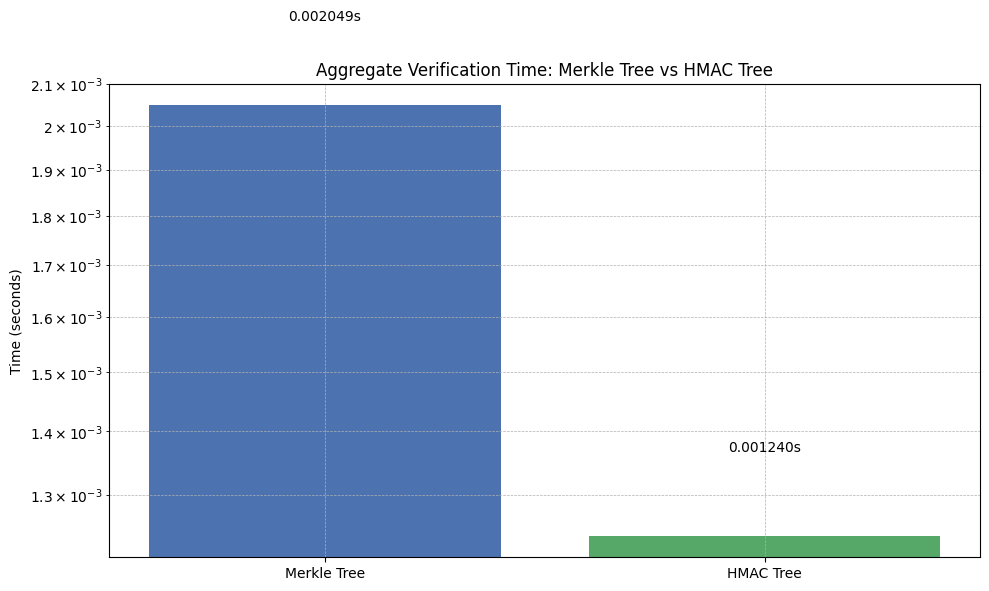

In [39]:
import matplotlib.pyplot as plt

# Use actual timing variables from your script
labels = ['Merkle Tree', 'HMAC Tree']
times = [merkle_verification_time, hmac_verification_time]
colors = ['#4c72b0', '#55a868']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=colors)
plt.ylabel("Time (seconds)")
plt.yscale("log")  # Use log scale to make small differences more visible
plt.title("Aggregate Verification Time: Merkle Tree vs HMAC Tree")

# Annotate each bar with the actual time value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval * 1.1, f"{yval:.6f}s", ha='center', va='bottom')

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

#### Tampering Simulation

In [40]:

# --- Tampering Simulation ---
print("\n--- Tampering Simulation ---")

# Tamper with last entry's temperature
tampered_entry = raw_data[-1].copy()
tampered_entry["temperature"] = 100.0  # Simulate unrealistic tamper

# Verify Merkle proof with tampered data
tampered_hash = hash_sensor_entry(tampered_entry)
tampered_index = len(leaves) - 1
proof = get_merkle_proof(updated_tree, tampered_index)
valid_merkle = verify_merkle_proof(tampered_hash, proof, updated_root, tampered_index)  # Pass index
print(f"Merkle Verification After Tampering: {valid_merkle}")

# Tampered temperature values
tampered_temps = [Decimal(str(e["temperature"])) for e in raw_data[:-1]] + [Decimal('100.0')]
tampered_avg = round(sum(tampered_temps) / len(tampered_temps), 2)
print(f"Tampered Average: {tampered_avg}")
print(f"Verify AVG MAC After Tampering: {hmac_tree.verify_aggregate_mac('AVG', tampered_avg, updated_avg_mac)}")



--- Tampering Simulation ---
Merkle Verification After Tampering: False
Tampered Average: 25.12
[DEBUG] Expected MAC for AVG: 439922.75
[DEBUG] Provided MAC: 96461.25
Verify AVG MAC After Tampering: False


### Benchmarking Code

#### Imports and Setup

In [41]:
import time
import matplotlib.pyplot as plt

# Import custom modules (adjust if needed)
from merkle_tool.merkle import build_merkle_tree, get_merkle_root, hash_sensor_entry
from hmac_tool.hmac import HMACTree


####  Load Sensor Data

In [42]:
# Load JSON sensor data (assumes this notebook is in the same folder as 'data/')
data_path = os.path.join('data', 'sensor_values.json')

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Sensor data file not found at: {data_path}")

with open(data_path, 'r') as f:
    sensor_data = json.load(f)["sensor_data"]

print(f"✅ Total Data Points Loaded: {len(sensor_data)}")


✅ Total Data Points Loaded: 999


#### Split the Dataset

In [43]:
# Use first 10 entries for initial build and rest for insertion
initial_entries = sensor_data[:10]
insertion_entries = sensor_data[10:]


#### Merkle Tree Benchmark

In [44]:
print("🔍 Benchmarking Merkle Tree...")

# Initial Build
initial_leaves = [hash_sensor_entry(entry) for entry in initial_entries]
start_build = time.perf_counter()
merkle_tree = build_merkle_tree(initial_leaves)
merkle_root = get_merkle_root(merkle_tree)
end_build = time.perf_counter()

# Simulated Insertions (rebuilding after each insert)
insert_start = time.perf_counter()
for entry in insertion_entries:
    initial_leaves.append(hash_sensor_entry(entry))
    merkle_tree = build_merkle_tree(initial_leaves)
insert_end = time.perf_counter()

# Timing results
merkle_build_time = round(end_build - start_build, 6)
merkle_insert_time = round(insert_end - insert_start, 6)

print(f"Merkle Root: {merkle_root}")
print(f"Initial Build Time: {merkle_build_time} sec")
print(f"Rebuild Time During Insertions: {merkle_insert_time} sec")


🔍 Benchmarking Merkle Tree...
Merkle Root: ddd0d260fd1fb12bbf2f9ff88177e976dddec8ccc81116ed947ba2e332649164
Initial Build Time: 0.000537 sec
Rebuild Time During Insertions: 1.671323 sec


#### HMAC Tree Benchmark

In [45]:
print("\n🔍 Benchmarking HMAC Tree...")

key = Decimal('7.25')
hmac_tree = HMACTree(key)

# Initial Build
start_build = time.perf_counter()
for entry in initial_entries:
    hmac_tree.insert(entry["timestamp"], entry["temperature"])
end_build = time.perf_counter()

# Insertions
insert_start = time.perf_counter()
for entry in insertion_entries:
    hmac_tree.insert(entry["timestamp"], entry["temperature"])
insert_end = time.perf_counter()

# Timing results
hmac_build_time = round(end_build - start_build, 6)
hmac_insert_time = round(insert_end - insert_start, 6)

print(f"Initial Build Time: {hmac_build_time} sec")
print(f"Insertion Time: {hmac_insert_time} sec")



🔍 Benchmarking HMAC Tree...
Initial Build Time: 0.0003 sec
Insertion Time: 0.012028 sec


#### Plot Performance Comparison

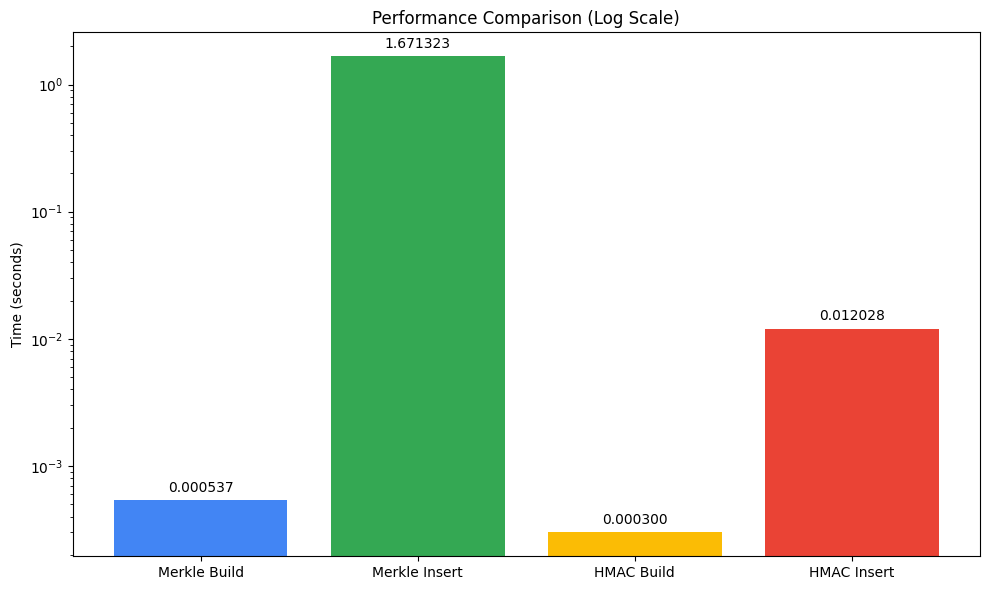

In [46]:
labels = ['Merkle Build', 'Merkle Insert', 'HMAC Build', 'HMAC Insert']
times = [merkle_build_time, merkle_insert_time, hmac_build_time, hmac_insert_time]
colors = ['#4285F4', '#34A853', '#FBBC05', '#EA4335']
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, times, color=colors)
plt.ylabel("Time (seconds)")
plt.yscale("log")  # 👈 Use log scale
plt.title("Performance Comparison (Log Scale)")

# Add value labels (still works on log scale)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval * 1.1, f"{yval:.6f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ZPK vs Merkle Tree

### Importing necessary functions

In [47]:
# --- Imports ---
import json
import time
import hashlib
import matplotlib.pyplot as plt
from decimal import Decimal

# Import predefined functions (already in your project)
# from merkle_tool.merkle import (
#     load_sensor_data, build_merkle_tree, get_merkle_root,
#     get_merkle_proof, verify_merkle_proof, hash_sensor_entry
# )
# from zkp_tool.zkp import generate_zkp_proof, verify_zkp_proof

# For this notebook, we assume the functions are already defined in the session.


### Loading Sensor Data

In [48]:
print("\n--- Loading Sensor Data ---")
raw_data, leaves = load_sensor_data("data/sensor_values.json")
print(f"Loaded {len(raw_data)} sensor entries")



--- Loading Sensor Data ---
Loaded 999 sensor entries


### Merkle Tree Verification Benchmark

In [49]:
print("\n--- Merkle Tree Verification ---")
tree = build_merkle_tree(leaves)
root = get_merkle_root(tree)

test_index = 10
proof = get_merkle_proof(tree, test_index)

start_merkle = time.perf_counter()
valid_merkle = verify_merkle_proof(leaves[test_index], proof, root, test_index)
end_merkle = time.perf_counter()

merkle_time = end_merkle - start_merkle
print(f"Merkle Proof Verification: {valid_merkle}")
print(f"Merkle Verification Time: {merkle_time:.6e} seconds")



--- Merkle Tree Verification ---
Merkle Proof Verification: True
Merkle Verification Time: 3.321001e-04 seconds


### ZKP Verification Benchmark

In [50]:
print("\n--- ZKP Verification ---")

# Use first sensor's auth token for proof
auth_token_hash = raw_data[0]["auth_token_hash"]

# Generate proof
proof = generate_zkp_proof("secret_key_A123")

# Verify proof
start_zkp = time.perf_counter()
valid_zkp = verify_zkp_proof(proof, auth_token_hash)
end_zkp = time.perf_counter()

zkp_time = end_zkp - start_zkp
print(f"ZKP Verification: {valid_zkp}")
print(f"ZKP Verification Time: {zkp_time:.6e} seconds")



--- ZKP Verification ---
ZKP Verification: True
ZKP Verification Time: 2.279000e-04 seconds


### Tampering Simulation

In [51]:
print("\n--- Tampering Simulation ---")

# Tamper sensor data
tampered_entry = raw_data[0].copy()
tampered_entry["temperature"] = 99.9
tampered_hash = hash_sensor_entry(tampered_entry)

# Merkle proof check (should fail)
tampered_proof = get_merkle_proof(tree, 0)
valid_merkle_tampered = verify_merkle_proof(tampered_hash, tampered_proof, root, 0)

# ZKP check with wrong secret
wrong_proof = generate_zkp_proof("wrong_secret")
valid_zkp_tampered = verify_zkp_proof(wrong_proof, auth_token_hash)

print(f"Merkle Verification After Tampering: {valid_merkle_tampered}")
print(f"ZKP Verification After Tampering: {valid_zkp_tampered}")



--- Tampering Simulation ---
Merkle Verification After Tampering: False
ZKP Verification After Tampering: False


### Comparison & Visualization

In [52]:
!pip install pandas


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


,Method,Verification Time (s),Valid
0,Merkle Tree,0.000332,True
1,ZKP,0.000228,True


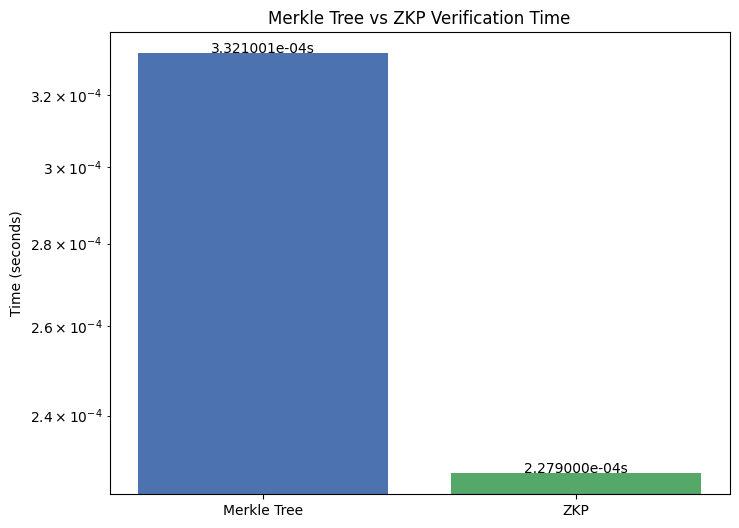

In [65]:
import pandas as pd

results = pd.DataFrame([
    {"Method": "Merkle Tree", "Verification Time (s)": merkle_time, "Valid": valid_merkle},
    {"Method": "ZKP", "Verification Time (s)": zkp_time, "Valid": valid_zkp},
])

display(results)

# Bar Chart
plt.figure(figsize=(8,6))
plt.bar(results["Method"], results["Verification Time (s)"], color=["#4c72b0", "#55a868"])
plt.ylabel("Time (seconds)")
plt.title("Merkle Tree vs ZKP Verification Time")
plt.yscale("log")
for i, v in enumerate(results["Verification Time (s)"]):
    plt.text(i, v, f"{v:.6e}s", ha='center')
plt.show()
